## HDBSCAN AND OUTLIER DETECTION

In [1]:
#importing libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from shapely.geometry import Point

import hdbscan

import geopandas
from geopandas import GeoDataFrame as gpd
import geoplot

import warnings
warnings.filterwarnings("ignore")


In [3]:
#importing dataset
uber_df=pd.read_csv('uber-raw-data-jun14.csv')
uber_df.head(2)

,Date/Time,Lat,Lon,Base
0,6/1/2014 0:00:00,40.7293,-73.9920,B02512
1,6/1/2014 0:01:00,40.7131,-74.0097,B02512


##### DATA PREPARATION

##### TASK 1

In [4]:
#first 1 lakh trips(rows)
df=uber_df[['Lat','Lon']]
df=df.iloc[:100000]
df

,Lat,Lon
0,40.7293,-73.9920
1,40.7131,-74.0097
2,40.3461,-74.6610
3,40.7555,-73.9833
4,40.6880,-74.1831
...,...,...
99995,40.7661,-73.9950
99996,40.7178,-73.9926
99997,40.6810,-73.9711
99998,40.7495,-73.9754


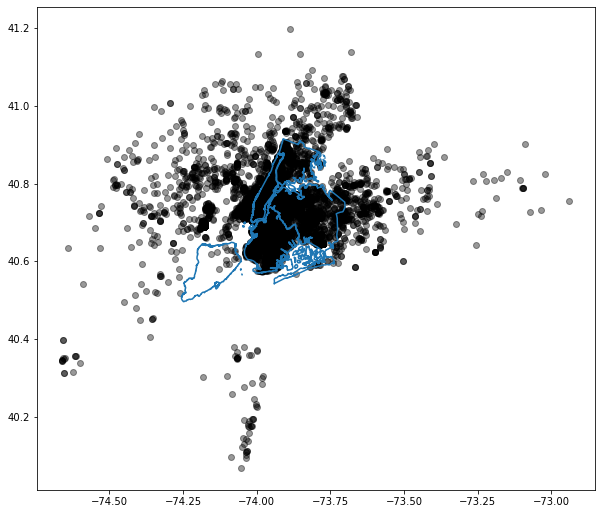

In [5]:
# plotting in map
gdf = gpd(df, geometry=geopandas.points_from_xy(df.Lon, df.Lat),crs=4326)
boroughs = geopandas.read_file(geoplot.datasets.get_path('nyc_boroughs'))

gdf.plot(ax=boroughs.boundary.plot(figsize=(10,10)),alpha=0.4,color="black")
plt.show()


Most of the trip are starting at the centre of the city.

we can see many outliers here

##### TASK 2

In [6]:
gdf=gdf.to_crs(3857)

In [7]:
print('LON:\n',gdf['geometry'].x,'\nLAT:\n',gdf['geometry'].y)

LON:
 0       -8.236752e+06
1       -8.238722e+06
2       -8.311225e+06
3       -8.235783e+06
4       -8.258025e+06
             ...     
99995   -8.237086e+06
99996   -8.236819e+06
99997   -8.234425e+06
99998   -8.234904e+06
99999   -8.237342e+06
Length: 100000, dtype: float64 
LAT:
 0        4.972495e+06
1        4.970116e+06
2        4.916365e+06
3        4.976345e+06
4        4.966430e+06
             ...     
99995    4.977902e+06
99996    4.970806e+06
99997    4.965402e+06
99998    4.975463e+06
99999    4.977800e+06
Length: 100000, dtype: float64


In [8]:
metre={'Lon_meters':gdf['geometry'].x,'Lat_meters':gdf['geometry'].y}
df_m = pd.concat(metre,axis = 1)
df_m

,Lon_meters,Lat_meters
0,-8.236752e+06,4.972495e+06
1,-8.238722e+06,4.970116e+06
2,-8.311225e+06,4.916365e+06
3,-8.235783e+06,4.976345e+06
4,-8.258025e+06,4.966430e+06
...,...,...
99995,-8.237086e+06,4.977902e+06
99996,-8.236819e+06,4.970806e+06
99997,-8.234425e+06,4.965402e+06
99998,-8.234904e+06,4.975463e+06


In [9]:
#SCALING the data
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler=StandardScaler()
df_scaled=scaler.fit_transform(df_m)
df1=pd.DataFrame(df_scaled,columns=df_m.columns)
df1

,Lon_meters,Lat_meters
0,-0.289557,-0.319464
1,-0.588585,-0.731206
2,-11.591787,-10.032261
3,-0.142578,0.346652
4,-3.518042,-1.368954
...,...,...
99995,-0.340240,0.616224
99996,-0.299694,-0.611760
99997,0.063532,-1.546769
99998,-0.009113,0.194084


##### TASK 3 (HDBSCAN)

Min_samples= 30 	Clusters= 503 	Outliers= 46864


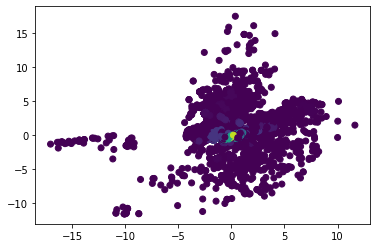

Min_samples= 40 	Clusters= 422 	Outliers= 6293


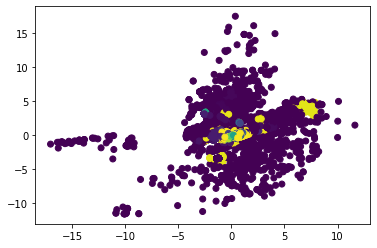

Min_samples= 50 	Clusters= 379 	Outliers= 4134


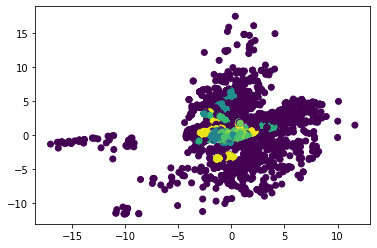

Min_samples= 60 	Clusters= 343 	Outliers= 3274


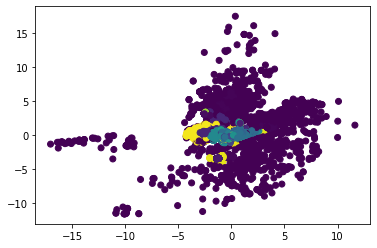

Min_samples= 70 	Clusters= 321 	Outliers= 2706


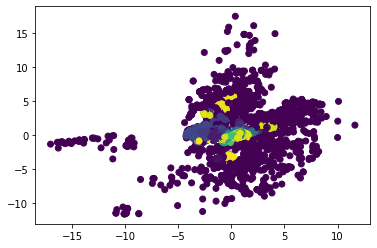

Min_samples= 100 	Clusters= 250 	Outliers= 3297


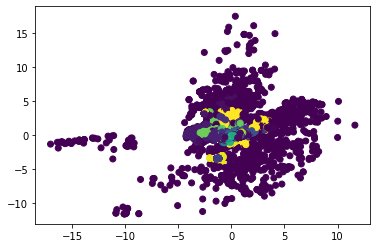

Min_samples= 200 	Clusters= 130 	Outliers= 6580


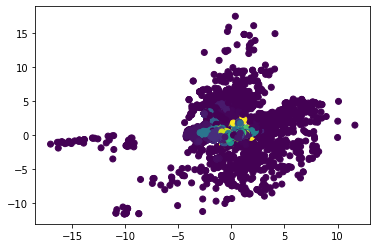

Min_samples= 300 	Clusters= 77 	Outliers= 8685


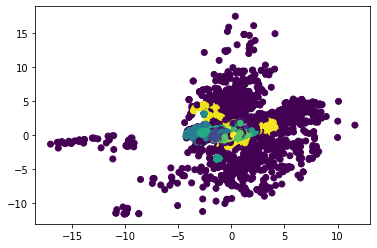

In [10]:
value=[30,40,50,60,70,100,200,300]
clt=[]
out=[]
for i in value:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=i)
    clusterer.fit_predict(df1)
    df1['clusterid'] = clusterer.labels_
    O=np.sum(df1['clusterid']==-1)
    clust=df1['clusterid'].nunique()-1
    print('Min_samples=',i,'\tClusters=',clust,'\tOutliers=',O)
    clt.append(clust);out.append(O)
    plt.scatter(df1['Lat_meters'], df1['Lon_meters'], c=clusterer.labels_)
    plt.show()

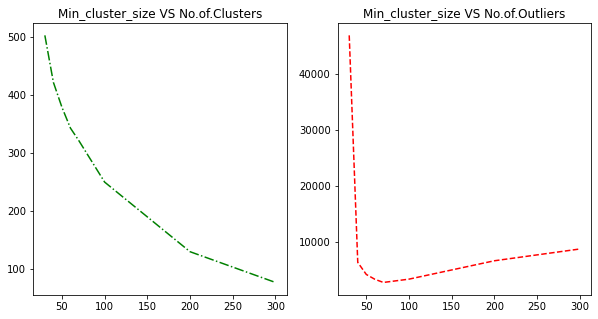

In [11]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(value,clt,'-.',color='green')
ax[0].set_title("Min_cluster_size VS No.of.Clusters")
ax[1].plot(value,out,'--',color='red')
ax[1].set_title("Min_cluster_size VS No.of.Outliers")
plt.show()

Min_samples= 70

OUTLIERS: 2706

We are choosing min_cluster_size as 70 as they have low outliers compared to other cluster_size

##### TASK 4

Clusters= 249 OUTLIERS: 1988


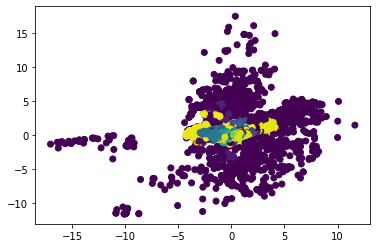

In [14]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=70)
clusterer.fit_predict(df1)
df1['clusterid'] = clusterer.labels_
O=np.sum(df1['clusterid']==-1)
clust=df1['clusterid'].nunique()-1
print('Clusters=',clust,'OUTLIERS:',O)
plt.scatter(df1['Lat_meters'], df1['Lon_meters'], c=clusterer.labels_)
plt.show()

In [17]:
#OUTLIERS
df2=df1.copy()
outliers=df2[df2.clusterid==-1]
outliers

,Lon_meters,Lat_meters,clusterid
2,-11.591787,-10.032261,-1
7,-0.076690,-11.090925,-1
11,-0.757527,-3.156417,-1
20,-2.176641,1.720392,-1
30,6.273845,0.486519,-1
...,...,...,...
99488,2.364524,2.532441,-1
99674,6.959750,1.030839,-1
99787,2.903449,-2.024238,-1
99920,-1.088654,-0.085590,-1


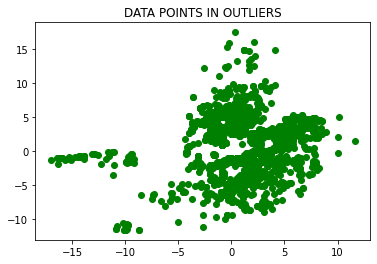

In [32]:
#plotting outliers
plt.scatter(outliers['Lat_meters'], outliers['Lon_meters'],color='green')
plt.title('DATA POINTS IN OUTLIERS')
plt.show()

In [18]:
#CLUSTERS
clusters=df2[df2.clusterid!=-1]
clusters

,Lon_meters,Lat_meters,clusterid
0,-0.289557,-0.319464,211
1,-0.588585,-0.731206,232
3,-0.142578,0.346652,202
4,-3.518042,-1.368954,0
5,-0.284489,-0.677837,144
...,...,...,...
99995,-0.340240,0.616224,232
99996,-0.299694,-0.611760,232
99997,0.063532,-1.546769,101
99998,-0.009113,0.194084,195


In [29]:
clusters['clusterid'].nunique()

249

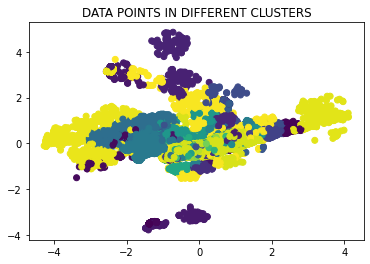

In [31]:
#plotting clusters
plt.scatter(clusters['Lat_meters'], clusters['Lon_meters'],c=clusters['clusterid'])
plt.title('DATA POINTS IN DIFFERENT CLUSTERS')
plt.show()

##### TASK 5

In [38]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=70).fit(df1)
clusterer

HDBSCAN(min_cluster_size=70)

In [44]:
#extracting outlier score
clusterer.outlier_scores_

array([4.01698409e-01, 4.95552574e-02, 4.58081178e-01, ...,
       9.99420273e-02, 4.00057442e-07, 2.74268794e-01])

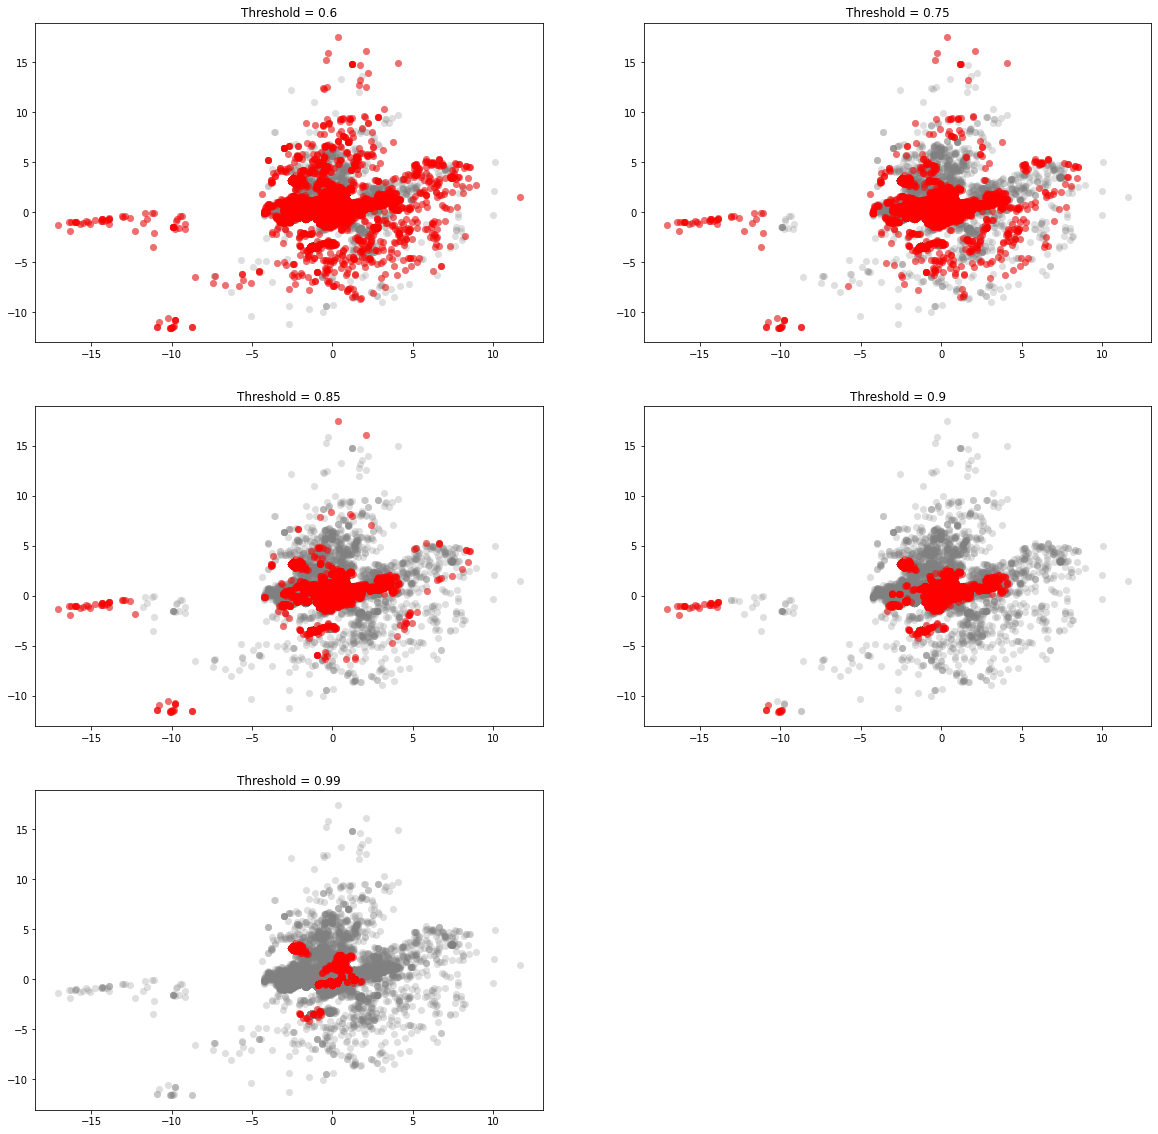

In [51]:
c=1
fig = plt.figure(figsize=(20,20))
for quant in [0.6,0.75,0.85,0.9,0.99]:
    
    plt.subplot(3, 2, c)
    plt.title('Threshold = '+ str(quant))
    threshold = pd.Series(clusterer.outlier_scores_).quantile(quant)
    outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
    plt.scatter(df1['Lat_meters'],df1['Lon_meters'] ,s=50, linewidth=0, c='gray', alpha=0.25)
    plt.scatter(df1['Lat_meters'].iloc[outliers],df1['Lon_meters'].iloc[outliers], s=50, linewidth=0, c='red', alpha=0.5)
    c=c +1

 As threshold increases, the outlier decreases

In [52]:
#END